## Inner MSM obtained with milestoning
We obtain the inner MSM model to obtain the biggest possible lag time with a decent resolution of the intrinsic timescales.

In [2]:
import numpy as np
import pyemma
import matplotlib.pyplot as plt
import pyemma.plots as mplt
import h5py
from MSMRD.trajectories import allTrajs_inner
%matplotlib inline

In [ ]:
# Create a child class from the main class in trajectories_class.py
class asym2Dtraj(allTrajs_inner):
    def __init__(self, centers=None, Trajs=None):
        super(asym2Dtraj, self).__init__(Trajs)
        if centers == None:
            centers = []
        self.centers = centers
        self.innerMSMrad = 2.0
        self.entryRad = 2.6
        self.bathRad = 3.0
        self.bathRadOut = 4.0
        self.angularPartitions = 15
        self.Ncenters = len(self.centers)
    
    # Overwrite getState function in parent class
    #discretize trajectory: use two additional rings of states for entry and exit states
    #cluster volume should be on the same order of magnitute as for the internal states
    def getState(self, coord, prevst):
        cen2coord = self.centers - coord
        norm = np.linalg.norm(cen2coord, axis = 1)
        index = np.argmin(norm)
        if (norm[index] <= 0.2 ):
            return index
        # if no new state found, return previous state
        return prevst

        
    # Overwrite getMilestones function
    def getMilestones(self):
        int_th = 2*np.pi/self.angularPartitions
        # inner MSM
        for i in range(self.Ncenters):
            self.milestones[i] = self.centers[i]
    
    # Overwrite getRegionMap function
    def getRegionMap(self):
        for i in range(self.Ncenters):
            statename = 'Inner state ' + str(i)
            self.regionMap[i] = statename

In [4]:
# Define filter for trajectory extraction from file
def filter(f, stride):
    for i, line in enumerate(f):
        if (not i%stride):
            yield line
# Extract trajectories from file using allTrajs class
fname = '../data/2DmodifiedLJmultipleTrajsLongR4.txt'
alltrajs = allTrajs_inner([]) # define allTrajs object
dimension = 2
with open(fname) as f:
    data = np.genfromtxt(filter(f, 1))
    ntrajs = data.shape[1]/dimension
    for i in range(0, ntrajs):
        traj = data[:,2*i:2*i+dimension]
        alltrajs.Trajs.append(traj)

In [5]:
# Calculate discrete trajectories and make sure it is clean (no "None" elements)
dtrajs = alltrajs.getdTrajsclean()
# Obtain centers of each state and save
centersdict = alltrajs.getMilestones()
centers = alltrajs.getMilestonesArray()

In [6]:
# Obtained implied time scales using pyemma
its = pyemma.msm.its(dtrajs, lags = 100)

estimating MaximumLikelihoodMSM: 100% (11/11) [####################] eta 00:00 |

(array([  1.00000000e-01,   1.00000000e+00,   1.00000000e+01,
          1.00000000e+02,   1.00000000e+03]),
 <a list of 5 Text yticklabel objects>)

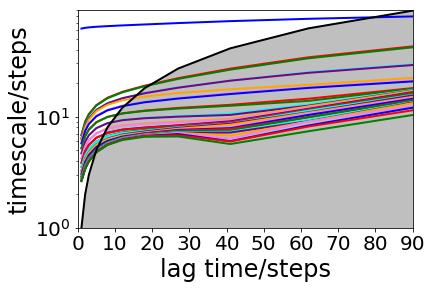

In [12]:
# Plot implied time scales
mplt.plot_implied_timescales(its, ylog=False, units='steps', linewidth=2, dt=1)
plt.ylabel(r"timescale/steps", fontsize = 24)
plt.xlabel(r"lag time/steps", fontsize = 24)
plt.xlim(0,90)
plt.ylim(0,90)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

From this notebook, we can get an ideal lag time for the inner MSM, where the milestoning works well since it is only defined between metastable states. In this case, it is given by the intersection between the accepted lag times ($\tau<t_{timescales}$) and the smallest timescale. In this case, this is given by $\tau \approx 10$. We will later use this lag time to obtain ideal parameters for the outer MSM.

In [8]:
# Choose lag time and obtain MSM "M" for our milestones
msm_lag = 10
M = pyemma.msm.estimate_markov_model(dtrajs, msm_lag, reversible=True)

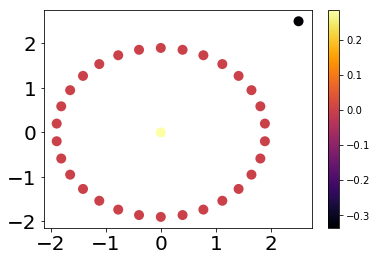

In [9]:
# Plot states and color them according to their weight in a given eigenmode
eigenmode = 1 # 0 = stationary distribution
vectors = M.eigenvectors_left()
value = M.eigenvalues()
#print M.timescales()[:10] 
#print -msm_lag/np.log(value[1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sc = plt.scatter(centers[:,0], centers[:,1], c=vectors[eigenmode][:], cmap=plt.cm.inferno, linewidths = 0, s=100)
plt.colorbar()